# Linear Discriminant Analysis (LDA)
### Supervised dimensionality reduction using an example

* used dataset: Statlog (Vehicle Silhouettes) https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29, Turing Institute, Glasgow, Scotland. Statlog Data Set. Feb. 13, 1993.
* implementation based on an university assignment I had to turn in
* some background on LDA: http://research.cs.tamu.edu/prism/lectures/pr/pr_l10.pdf
* function ```create_surface_plot``` based on https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html with little modifications

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pprint import pprint
%matplotlib inline

In [2]:
from pprint import pprint
from sklearn import svm
from sklearn.metrics import confusion_matrix
import glob
import csv

In [3]:
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12,8)})

In [4]:
np.random.seed(23)

First of all, I downloaded the dataset Statlog (Vehicle Silhouettes) from https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29, the files are stored in the folder ``origin_data_files``. 
To split the data differently as needed, I created a function called ```concat_data_chunks(...)``` to concatenate the data.

In [5]:
def concat_data_chunks(file_list, header, delimiter=' '):
    """
    Receives a list of filenames, true if a header is present and the delimiter of the data within the files.
    The data will be read in as CSV via the modul pandas. 
    
    Returns the data and the corresponding labels. 
    """
    data_list = [pd.read_csv(f_name, delim_whitespace=True, header=header) for f_name in file_list]
    data = []
    labels = []
    for l in data_list:
        data.append(l.iloc[:,:-1].values)
        labels.append(l.iloc[:,-1].values)
    data = np.vstack(data)
    labels = np.hstack(labels)
    d = np.append(data, labels.reshape(-1,1), axis=1)
    np.random.shuffle(d)
    data = d[:,:-1]
    labels = d[:,-1]
    return data, labels

In [6]:
def string_labels_to_number(labels, order=None):
    """
    Converts string labels to numerical values. 
    Class label and a corresponding number may be provided as a list of tuples
    where a tuple is (class_name, number). If not, the order is created based
    on the distinct class names.
    
    Returns the numerical labels, a list of the unique class names and a list of 
    corresponding numbers where each number represents a class.
    """
    if order and type(order[0]) == tuple:
        unique_classes = [x[0] for x in order]
        unique_numbers = [x[1] for x in order]
    elif order:
        print('Given order list does not contain tuples in form of (class_label, number). Creating order from data...')
        unique_classes = list(set(labels))
        unique_numbers = list(range(1,len(unique_classes)+1))
    else:
        unique_classes = list(set(labels))
        unique_numbers = list(range(1,len(unique_classes)+1))
    labels_n = np.zeros((labels.shape))
    idx_of_classes = [np.where(labels==c)[0].tolist() for c in unique_classes]
    for i, e in enumerate(idx_of_classes):
        labels_n[e] = unique_numbers[i]
    return np.array(labels_n), unique_classes, unique_numbers

Get the filenames and concatenate the data:

In [7]:
file_names = glob.glob('origin_data_files/*')
data, labels = concat_data_chunks(file_names, header=None)

In [8]:
# providing an order for the conversion of string labels to numerical values
class_number_pairs = [('opel', 1), ('saab', 2), ('bus', 3), ('van', 4)]

Conversion of string labels to numbers:

In [9]:
labels_n, class_names, class_numbers = string_labels_to_number(labels, order=class_number_pairs)

For supervision purpose:

In [10]:
class_names_number = list(zip(class_names, class_numbers))

In [11]:
for tup in class_names_number:
    print('Class name and its corresponding number: {} -> {}'.format(tup[0], tup[1]))

Class name and its corresponding number: opel -> 1
Class name and its corresponding number: saab -> 2
Class name and its corresponding number: bus -> 3
Class name and its corresponding number: van -> 4


#### Data distribution - number of samples within each class

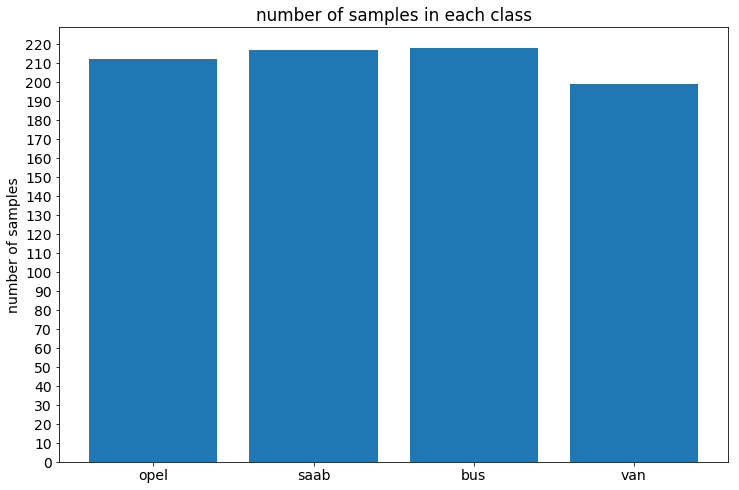

In [12]:
amount_samples = [len(labels_n[labels_n==i]) for i in class_numbers]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
ax.bar(class_numbers, amount_samples)
ax.set_xticks(class_numbers)
ax.set_yticks(range(0,max(amount_samples)+10,10))
ax.set_xticklabels((class_names))
ax.set_ylabel('number of samples')
ax.set_title('number of samples in each class')
plt.show()

In [13]:
def split_data(data, labels_n, split=9, test_part=1, dtype=np.float64):
    
    train_data_idx = int(data.shape[0] / split * (split - test_part))
    
    train_data = data[:train_data_idx, :]
    train_labels = labels_n[:train_data_idx]
    
    test_data = data[train_data_idx:,:]
    test_labels = labels_n[train_data_idx:]
    
    return train_data, train_labels, test_data, test_labels

In [14]:
def write_csv_file(data, filename, delimiter=','):
    with open(filename + '.csv', mode='w') as csv_file:
        data_writer = csv.writer(csv_file, delimiter=delimiter)
        for row in data:
            data_writer.writerow(row)

In [15]:
train_data, train_label, test_data, test_labels = split_data(data, labels_n)

In [16]:
training_data_l = np.append(train_data, train_label.reshape(-1,1), axis=1).astype(np.int32)
test_data_l = np.append(test_data, test_labels.reshape(-1,1), axis=1).astype(np.int32)

In [17]:
write_csv_file(training_data_l, 'new_train')
write_csv_file(test_data_l, 'new_test')

# Linear Discriminant Analysis with more than 2 classes

Generalization of the within-class scatter matrix for classes > 2:

$$S_W = \Sigma = \sum\limits_{i=1}^{C} \Sigma_i$$

which means adding up all (total) covariance matrices from each class (mind the missing fraction). For a more clear view:

$$\Sigma_i = \sum\limits_{x_k \in C_i}^{} (x_k - m_i)(x_k - m_i)^T$$

where $x_k$ is a data point in class $C_i$ and $m_i$ is the mean vector of class $C_i$.

The between-class matrix is adjust by the concept of maximizing the mean value $\mu_i$ from each class which creates an overall mean value $\mu$ based on all observations. 
The overall mean value $\mu$ is computed as follows:

$$\mu = \frac{1}{C} \sum\limits_{c=1}^{C}\mu_c$$



After the computed overall mean value, the between-class matrix is computed as below:

$$S_B = \sum\limits_{i=1}^{C} N_i (\mu_i - \mu)(\mu_i - \mu)^T$$

where $N_i$ is the number of points of a class $C_i$ which is used to weight each matrix. 

## LDA Implementation

In [18]:
def LDA(data, labels):
# assumation: observations are in rows and features are in columns
    n_features = data.shape[1]
    class_labels = list(set(labels))  # possible labels
    n_classes = len(class_labels)
    S_W = np.zeros((n_features, n_features))
    S_B = np.zeros((n_features, n_features))
    
    # list of lists where the first dimemsion corresponds to the class
    # and the second dimension holds the indices where the class in the data array occurs
    idx_of_classes = [np.where(labels==c)[0].tolist() for c in class_labels]

    # array of mean values along all features and all observations, results in a (n_features, ) array
    overall_mean_data = np.mean(data, axis=0)
    
    for i, idx_class in enumerate(idx_of_classes):
        # S_W += (len(data[idx_class]) - 1) * np.cov(data[idx_class].transpose())
        
        # calculation of S_W -> dim: (n_features, n_features)
        S_W += (len(data[idx_class]) - 1) * np.cov(data[idx_class], rowvar=False)
        
        # class mean minus overall mean
        v = (np.mean(data[idx_class,:], axis=0) - overall_mean_data).reshape(-1,1)
        
        # calculation of S_W by summing up all outer products of v weighted with the amount
        # of observations within the class
        S_B += data[idx_of_classes[i]].shape[0] * np.outer(v,v)

    # dimension: (n_features, n_features)
    S_W_inv = np.linalg.pinv(S_W)
    
    # dimension: (n_features, n_features)
    S_W_inv_S_B = np.matmul(S_W_inv, S_B)
    
    # compute eigenvalues w and eigenvectors v of the matrix S_W_inv_S_B
    eig_vals, eig_vecs = np.linalg.eig(S_W_inv_S_B)


    # sort eigenvalues descending and store the indices
    sorted_indices = np.argsort(eig_vals)[::-1]
    # sort eigenvalues and eigenvector according to the descending order of the eigenvalues
    eig_vals = eig_vals[sorted_indices]
    # eigenvectors, each column of the matrix is an eigenvector as it is stated in the documentation
    eig_vecs = eig_vecs[:, sorted_indices]

    coefficients = eig_vecs
    latents = eig_vals
    projections = np.matmul(data, coefficients)
    # projections = data.dot(coefficients)  # calculates np.matmul(...) since the dimension of both matrices are identical
    return coefficients, projections, latents

## Load the data and store it in numpy arrays with type np.float64

In [19]:
def load_data(list_of_file_names, delimiter=','):
    """
    No exception handling, if a filename is in correct a crash will occur.
    Reads all files specified in the list list_of_file_names. Creates a list
    of lists for the loaded data and labels. 
    For example if you load a train data and a test data file, then the csv_list will 
    contain to entries. Also, data_list and label_list will hold two entries, the csv
    data without the label is contained in data_list, the labels of that correspodning data
    is stored in separated lists within label_list.
    """
    csv_data = [np.genfromtxt(f_name, delimiter=delimiter, dtype=np.float64) for f_name in list_of_file_names]
    data_list = [data[:,:-1] for data in csv_data]
    label_list = [data[:,-1] for data in csv_data]
    return data_list, label_list

## Specification of filenames and class names

In [20]:
file_name_train = 'new_train.csv'
file_name_test  = 'new_test.csv'

In [21]:
class_names = ['OPEL', 'SAAB', 'BUS', 'VAN']

In [22]:
data_l, label_l = load_data([file_name_train, file_name_test])
train_data = data_l[0]
train_label = label_l[0]
test_data = data_l[1]
test_label = label_l[1]
n_features = train_data.shape[1]

## Training Phase

In [23]:
coefficients, projections, latents = LDA(train_data, train_label)

In [24]:
print("First 3 eigenvalues (adjusted method):")
pprint(latents[:3])

First 3 eigenvalues (adjusted method):
array([2.42250681+0.j, 2.01420742+0.j, 0.1627246 +0.j])


In [25]:
# calculate percentage part of each eigenvalue
sum_latent = np.sum(latents)
eigenvalues_perc = [np.abs(l/sum_latent) for l in latents]
print("Sum of eigenvalues: {}".format(sum_latent))

Sum of eigenvalues: (4.599438835075605+0j)


## Percentage explained

In [26]:
print("Percentage part of each eigenvalue:")
pprint(eigenvalues_perc)

Percentage part of each eigenvalue:
[0.5266961679327038,
 0.4379246023476674,
 0.03537922971963989,
 6.302592821759578e-15,
 4.0118692540515504e-16,
 4.0118692540515504e-16,
 1.6599328985757278e-16,
 1.1306972593641564e-16,
 9.019569051893616e-18,
 1.5827050453458238e-16,
 1.5827050453458238e-16,
 8.358123486372998e-17,
 3.411812467797436e-16,
 3.411812467797436e-16,
 7.939458478402018e-16,
 3.422057975480074e-15,
 3.422057975480074e-15,
 1.4777347529346035e-14]


## Choose dimensionality of the new feature space: d=2

The first 2 eigenvalues have the heighest value (since they where already sorted). The first eigenvalue is the most important one, since it has the heighest percentage value which is approximately 53.4 \%.

In [27]:
print("Eigenvectors d=2:")
pprint(coefficients[:,:2])

Eigenvectors d=2:
array([[-0.00322105+0.j, -0.16388471+0.j],
       [ 0.0329591 +0.j,  0.75240093+0.j],
       [-0.01466229+0.j, -0.17836559+0.j],
       [-0.16175103+0.j,  0.06871088+0.j],
       [ 0.44634288+0.j, -0.16108926+0.j],
       [-0.17095302+0.j,  0.06980598+0.j],
       [-0.1098777 +0.j,  0.28037769+0.j],
       [-0.431429  +0.j, -0.25463419+0.j],
       [-0.54754942+0.j,  0.21093686+0.j],
       [ 0.04744698+0.j, -0.36722714+0.j],
       [ 0.00286464+0.j, -0.02144262+0.j],
       [ 0.02754141+0.j, -0.03972198+0.j],
       [-0.00105368+0.j, -0.01321539+0.j],
       [ 0.05566052+0.j, -0.07467988+0.j],
       [-0.07312191+0.j,  0.05390767+0.j],
       [ 0.02612959+0.j,  0.03029731+0.j],
       [ 0.41713704+0.j, -0.02007832+0.j],
       [-0.24477245+0.j, -0.06971183+0.j]])


## Train a SVM - use the new dimensional reduced data

Reduce the values to real numbers by adding the real and imaginary part. This is done using the following function:

In [28]:
def complex_projection_to_real(p):
    """ Adds the imaginary and the real part on an array level."""
    proj_real = np.real(p)
    proj_imag = np.imag(p)
    projection_real = np.add(proj_real, proj_imag)
    return projection_real

Using function above, the real and imaginary part of the projections are added up.

In [29]:
projection_real = complex_projection_to_real(projections)

Since the first and second dimension has the heighest percentage eigenvalues, only this dimensions will be used to test classification. Therefore: $d=2$.

Create projection vector:

In [30]:
W = np.hstack((coefficients[:,0].reshape(n_features,1), coefficients[:,1].reshape(n_features,1)))

In [31]:
train_proj_d_2 = projection_real[:, :2]
print(train_proj_d_2.shape)

(752, 2)


In [32]:
clf = svm.SVC(kernel='rbf', gamma='auto')
# clf = DecisionTreeClassifier()
# clf = MLPClassifier(alpha=1)

In [33]:
clf.fit(train_proj_d_2, train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Plot the decision boundaries

In [34]:
def create_surface_plot(clf, data, labels, colormap_schema='coolwarm', labels_axis=['LDA1', 'LDA2'], steps=0.02, class_names=''):
    """
    With help from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    Plot the data points and the decision boundaries for a classifier.
    Plots are created with 2 dimensions, even when data contains more than 2.
    
    Parameters
    ----------
    clf: a classifier
    data: Row-wise observations, used for plotting and for creating a meshgrid for the 2 dimensions.
    labels: the class labels for each observation in data.
    colormap_schema: color map used for the plot
    steps: spacing between the values in the meshgrid
    class_names: used for the legend of the plot
    """
    
    # arrays from which the meshgrid will be created
    x = data[:,0]
    y = data[:,1]
    
    # possible classes without duplicates
    classes = list(set(labels))
    n_classes = len(classes)
    # color map used for the plotting and amount of different colors
    cm = plt.cm.get_cmap(colormap_schema, n_classes)
    
    # min and max values of the data for both axis
    # -1/+1 to have more space in each direction and to so clearly the data
    x_min = x.min() - 1
    x_max = x.max() + 1
    y_min = y.min() - 1
    y_max = y.max() + 1
    
    # create meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, steps),
                         np.arange(y_min, y_max, steps))
    
    # prediction for each point in the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # reshape for the grid
    Z = Z.reshape(xx.shape)
    
    # create figure and plot the data and the predictions for each point
    # in the grid
    plt.figure()
    # contour plot
    plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap(colormap_schema), alpha=0.6)
    
    # plot the data and color the points corresponding to their classes
    for i in range(n_classes):
        curr_class_data = data[np.where(labels==classes[i])[0].tolist()]
        plt.scatter(curr_class_data[:,0], curr_class_data[:,1], c=cm(i), label=class_names[i])
    plt.xlabel(labels_axis[0])
    plt.ylabel(labels_axis[1])
    plt.legend()
    plt.show()

Try to predict the labels from the training set.

In [35]:
preds_train = clf.predict(train_proj_d_2)

In [36]:
print("Pred. labels are equal to train labels in {} cases.".format(len(np.where(train_label==preds_train)[0])))

Pred. labels are equal to train labels in 576 cases.


### Plot the decision boundaries of the training data

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

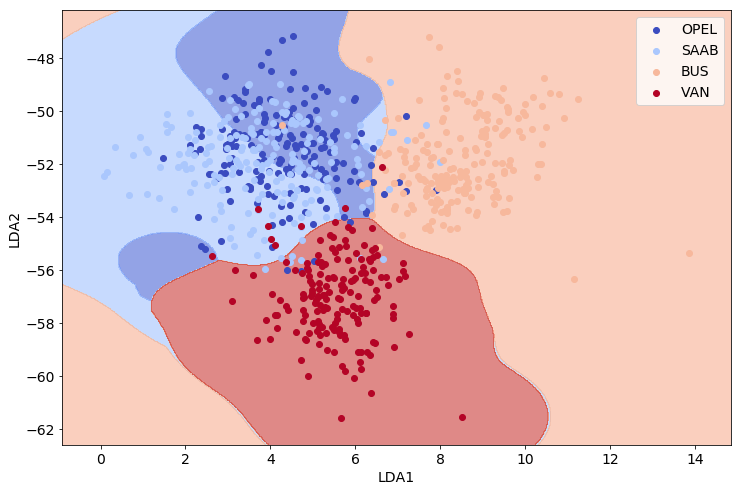

In [37]:
create_surface_plot(clf, train_proj_d_2, train_label, steps=0.02, class_names=class_names)

In [38]:
cm_train = confusion_matrix(train_label, preds_train)

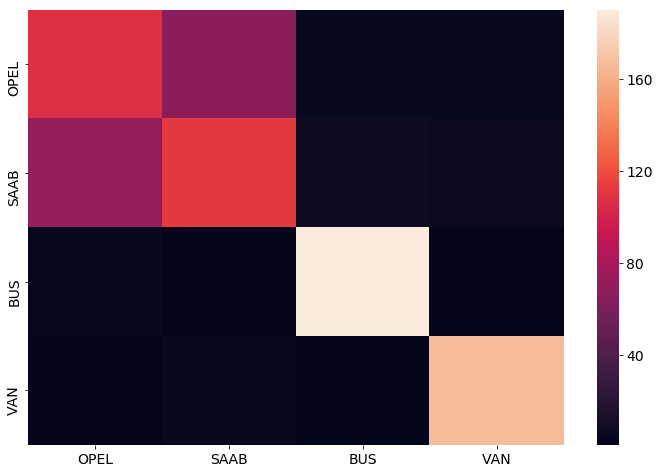

In [39]:
sns.heatmap(cm_train, xticklabels=class_names, yticklabels=class_names)
plt.show()

The contour plot shows that the classifier isn't sure about data from OPEL or SAAB. The confusion matrix approves the assumption and explains why the contour plot looks like it does. 

## Test Phase

Test data already loaded above.

### Projection of the test data to the dimensional reduced space

In [40]:
proj_test = np.matmul(test_data, W)
# adding up real and imaginary part 
test_proj_d_2 = complex_projection_to_real(proj_test)
print(test_proj_d_2.shape)

(94, 2)


### Predict labels of the test data

In [41]:
# predict classes of the test data
preds = clf.predict(test_proj_d_2)

In [42]:
print("Pred. labels are equal to test labels in {} cases.".format(len(np.where(test_label==preds)[0])))

Pred. labels are equal to test labels in 71 cases.


### Create confusen matrix

In [43]:
cm_test = confusion_matrix(test_label, preds)

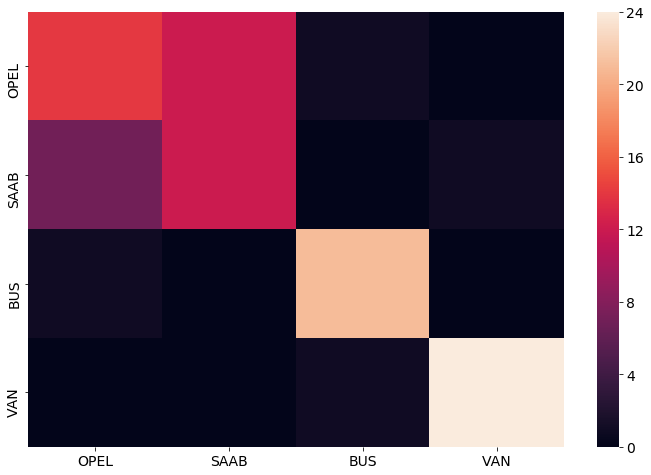

In [44]:
# plt.imshow(cm, cmap='hot')
sns.heatmap(cm_test, xticklabels=class_names, yticklabels=class_names)
plt.show()

### Plot of decision surfaces and test data

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

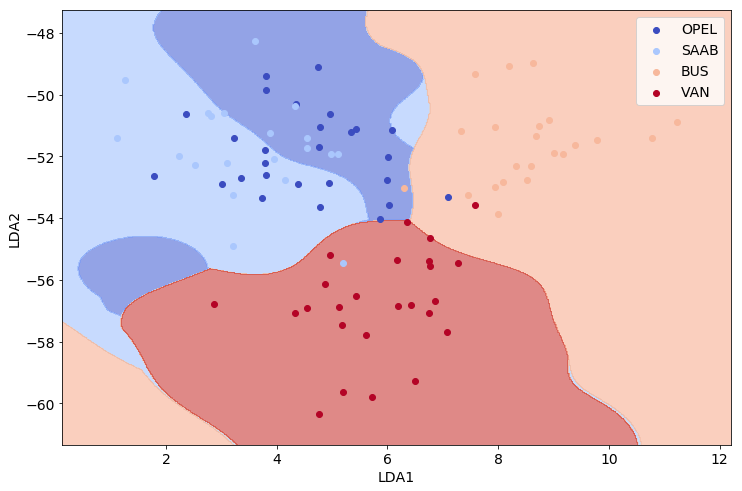

In [45]:
create_surface_plot(clf, test_proj_d_2, test_label, steps=0.02, class_names=class_names)

The data set is not clearly separable in the case we process it. Class boundaries are overlapping, so it doesn't matter how good our classifier works if the data ist not preprocessed in a good way. 